In [1]:
%load_ext line_profiler

In [2]:
import glob
import os

from ncempy.io import dm
import numpy as np
from skimage import filters
from skimage.measure import regionprops
import tensorflow as tf
import pandas as pd

In [3]:
# INPUT

# Select measured PACBED
file_PACBED = '/cachedata/users/weber/PACBED-CNN-data/Measured_PACBED/PACBED_0.dm4'

# Select folder with CNN models and labels (for a specific system)
path_models = '/cachedata/users/weber/PACBED-CNN-data/Trained_Models/'

dataframe_path = '/cachedata/users/weber/PACBED-CNN-data/Trained_Models/df.csv'

simulation_path = '/cachedata/users/weber/PACBED-CNN-data/'


In [4]:
# Use GPU
gpu = True

if gpu:
     Code Snippet limits GPU memory growth -> without, errors occur (may not necessary for cluster/other computers)
    config = tf.compat.v1.ConfigProto(gpu_options=
                                      tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
                                      # device_count = {'GPU': 1}
                                      )
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [5]:
# Load PACBED (dm-file)
img_PACBED = dm.dmReader(file_PACBED)
PACBED_measured = img_PACBED['data']

In [6]:
# Convert to grayscale, if loaded PACBED is RGB
if len(PACBED_measured.shape) > 2:
    PACBED_measured = PACBED_measured[:,:,0]

In [7]:
# Function for finding center of mass
def center_of_mass(image):
    threshold_value = filters.threshold_otsu(image)
    labeled_foreground = (image > threshold_value).astype(int)
    properties = regionprops(labeled_foreground, image)
    com = properties[0].centroid
    return com

In [8]:
# Function for cropping the maximum square around the center of mass (or shifting better? Square --> input for CNNs)
def cropping_center_of_mass(PACBED, com):
    # Finding maximum boundaries for the square
    if PACBED.shape[0] / 2 < com[0]:
        side_0 = PACBED.shape[0] - com[0]
    else:
        side_0 = com[0]
    if PACBED.shape[1] < com[1]:
        side_1 = PACBED.shape[1] - com[1]
    else:
        side_1 = com[1]

    square_side = side_0 if side_0 <= side_1 else side_1

    # Define boundaries
    x_0 = int(com[0] - square_side)
    x_1 = int(com[0] + square_side)
    y_0 = int(com[1] - square_side)
    y_1 = int(com[1] + square_side)

    # Crop image
    PACBED_cropped = PACBED[x_0:x_1, y_0:y_1]

    return PACBED_cropped

In [9]:
def preprocess(PACBED_measured):
    # Calculate Center of Mass
    com = center_of_mass(PACBED_measured)
    com_cropping = np.round(com)

    # Crop measured PACBED
    return cropping_center_of_mass(PACBED_measured, com_cropping)

In [10]:
def redim(dim, PACBED_cropped):
    dim = dim
    img = PACBED_cropped[:,:,np.newaxis]
    # from high resolution (4kx4k,..) to smaller resolution
    img = tf.keras.preprocessing.image.smart_resize(img, (4*dim[0],4*dim[1]), interpolation='bilinear')
    return img, dim

In [11]:
def rescale_resize(img, scale, dim):
    # Scale image (with full pixels)
    img = tf.keras.preprocessing.image.apply_affine_transform(
        img,
        zx=1/scale,
        zy=1/scale,
        row_axis=0,
        col_axis=1,
        channel_axis=2,
        fill_mode='nearest',
        cval=0.,
        order=1
    )
    # Resize and normalize image for next predictions
    img_arr = tf.keras.preprocessing.image.smart_resize(img, dim[0:2], interpolation='bilinear')
    img_arr /= np.amax(img_arr)
    return (img, img_arr)

In [12]:
class Predictor:
    def __init__(self, path_models, dataframe_path, simulation_path):
        self.simulation_path = simulation_path
        # Get all filenames of CNNs and labels
        model_names = [os.path.basename(x) for x in glob.glob(path_models + '*.tflite')]
        labels_names = [os.path.basename(x) for x in glob.glob(path_models + '*_labels.csv')]
        
        # Load all models and labels       
        for i in range(0, len(model_names)):

            # Load all models to the correct variables
            if model_names[i].find('Scale') > -1:
                self.interpreter_scale = tf.lite.Interpreter(model_path=os.path.join(path_models, model_names[i]))
                self.interpreter_scale.allocate_tensors()
                self.scale_input_details = self.interpreter_scale.get_input_details()
                self.scale_output_details = self.interpreter_scale.get_output_details()
            elif model_names[i].find('Thickness') > -1:
                self.interpreter_thickness = tf.lite.Interpreter(model_path=os.path.join(path_models, model_names[i]))
                self.interpreter_thickness.allocate_tensors()
                self.thickness_input_details = self.interpreter_thickness.get_input_details()
                self.thickness_output_details = self.interpreter_thickness.get_output_details()
            elif model_names[i].find('Mistilt') > -1:
                self.interpreter_tilt = tf.lite.Interpreter(model_path=os.path.join(path_models, model_names[i]))
                self.interpreter_tilt.allocate_tensors()
                self.tilt_input_details = self.interpreter_tilt.get_input_details()
                self.tilt_output_details = self.interpreter_tilt.get_output_details()
                
                

            # Load all labels to the correct variables
            if labels_names[i].find('Scale') > -1:
                self.label_scale = pd.read_csv(os.path.join(path_models, labels_names[i]))
            elif labels_names[i].find('Thickness') > -1:
                self.label_thickness = pd.read_csv(os.path.join(path_models, labels_names[i]))
            elif labels_names[i].find('Mistilt') > -1:
                self.label_mistilt = pd.read_csv(os.path.join(path_models, labels_names[i]))
        
        # Load dataframe (csv-file with out index)
        self.dataframe = pd.read_csv(dataframe_path)
    
    def predict(self, PACBED_measured):
        PACBED_cropped = preprocess(PACBED_measured)
        # Extract required dimension from the thickness CNN (assumed that all CNNs have same input)
        img, dim = redim(self.thickness_input_details[0]['shape'][1:], PACBED_cropped)
        # Prepare image for CNN input by resizing and normalizing
        img_arr = tf.keras.preprocessing.image.smart_resize(img, dim[0:2], interpolation='bilinear')
        img_arr /= np.amax(img_arr)
        
        # Make CNN-predictions

        # Iterative scaling of the image
        k = 0
        scale_total = 1
        scale_pred = 1
        while True:
            # Make scale prediction
            img_arr = np.stack((img_arr[:, :, 0],)*3, axis=-1)
            
            
            self.interpreter_scale.set_tensor(self.scale_input_details[0]['index'], img_arr[np.newaxis, :, :, :])
            self.interpreter_scale.invoke()
            scale_prediction = self.interpreter_scale.get_tensor(self.scale_output_details[0]['index'])
            
            #scale_prediction = self.model_scale(img_arr[np.newaxis, :, :, :], training=False)  # call instead of predict may be faster
            # Get scaling value with the highest predicted value
            new_scale_pred = self.label_scale['Scale / []'][np.argmax(scale_prediction)]
            scale_pred = (k*scale_pred + (5-k)*new_scale_pred) / 5
            # print(new_scale_pred, scale_pred)
            # Break loop if scaling is 5, maximum runs of the loop is exceeded or the prediction is too low
            if np.abs(new_scale_pred - 1) < 0.05:
                break
            elif k > 5 or np.amax(scale_prediction) < 0.3:
                break
                # raise RuntimeError("Could not predict scale")
            else:
                img, img_arr = rescale_resize(img, scale_pred, dim[0:2])
                # Loop counter
                k += 1
                scale_total *= scale_pred
                
        # PACBED for validation
        self.PACBED_validate = img_arr[:, :, 0]
                
        # Make thickness prediction
        self.interpreter_thickness.set_tensor(self.thickness_input_details[0]['index'], img_arr[np.newaxis, :, :, :])
        self.interpreter_thickness.invoke()
        thickness_prediction = self.interpreter_thickness.get_tensor(self.thickness_output_details[0]['index'])
  
        
        #thickness_prediction = self.model_thickness(img_arr[np.newaxis, :, :, :],training=False)
        # Get thickness value with the highest predicted value
        thickness_pred = self.label_thickness['Thickness / A'][np.argmax(thickness_prediction)]

        # Make mistilt prediction
        self.interpreter_tilt.set_tensor(self.tilt_input_details[0]['index'], img_arr[np.newaxis, :, :, :])
        self.interpreter_tilt.invoke()
        mistilt_prediction = self.interpreter_tilt.get_tensor(self.tilt_output_details[0]['index'])
        
        
        
        #mistilt_prediction = self.model_tilt(img_arr[np.newaxis, :, :, :],training=False)
        # Get mistilt value with the highest predicted value
        mistilt_pred = self.label_mistilt['Mistilt / mrad'][np.argmax(mistilt_prediction)]
        result = {
            'thickness_prediction': thickness_prediction,
            'thickness_pred': thickness_pred,
            'mistilt_prediction': mistilt_prediction,
            'mistilt_pred': mistilt_pred,
            'scale': scale_total,
            
        }
        return result
    
    def validate(self, result):
        import matplotlib.pyplot as plt
        from PIL import Image


        # Plot imported PACBED and the scaled PACBED, which is used for thickness and mistilt prediction
        fig1, (ax11, ax12) = plt.subplots(1, 2)
        fig1.suptitle('PACBED')
        ax11.imshow(PACBED_measured)
        ax11.set_title('Loaded PACBED')
        ax12.imshow(self.PACBED_validate)
        ax12.set_title('PACBED for prediction')
        fig1.tight_layout() 


        # Plot output of the thickness model and the mistilt model

        # Sort thickness values (if labels are not ascended ordered)
        thickness_sort_ind = np.argsort(self.label_thickness.iloc[:,0])
        thickness_pred_sorted = np.array(result['thickness_prediction'])[0,thickness_sort_ind]
        thickness_values_sorted = np.array(self.label_thickness.iloc[:,0][thickness_sort_ind])

        # Sort mistilt values (if labels are not ascended ordered)
        mistilt_sort_ind = np.argsort(self.label_mistilt.iloc[:, 0])
        mistilt_pred_sorted = np.array(result['mistilt_prediction'])[0, mistilt_sort_ind]
        mistilt_values_sorted = np.array(self.label_mistilt.iloc[:, 0][mistilt_sort_ind])

        fig2, (ax21, ax22) = plt.subplots(2, 1)
        # Plot output of thickness prediction
        ax21.plot(thickness_values_sorted/10, thickness_pred_sorted)
        ax21.set_title('Thickness Prediction')
        ax21.set_xlim([np.amin(thickness_values_sorted)/10, np.amax(thickness_values_sorted)/10])
        ax21.set_ylim([0, 1])
        ax21.set_xlabel('Thickness / nm')
        # Plot output of mistilt prediction
        ax22.plot(mistilt_values_sorted,mistilt_pred_sorted)
        ax22.set_title('Mistilt Prediction')
        ax22.set_xlim([np.amin(mistilt_values_sorted), np.amax(mistilt_values_sorted)])
        ax22.set_ylim([0, 1])
        ax22.set_xlabel('Mistilt / mrad')
        fig2.tight_layout()  



        # Plot simulated PACBEDs with predicted values

        # Location of the simulated PACBEDs required

        # Get specific convergence angle for plotting (otherwise to many plots)
        conv_angle_unique = np.unique(self.dataframe['Conv_Angle'])
        # Take middle convergence angle (if convergence angle is known, closest value can be taken)
        conv_angle_plot = conv_angle_unique[len(conv_angle_unique)//2]

        # Filter dataframe for the predicted values (open value is azimuth)
        filteredDataframe = self.dataframe[
            (self.dataframe['Thickness'] == result['thickness_pred']) &
            (self.dataframe['Mistilt'] == result['mistilt_pred']) &
            (self.dataframe['Conv_Angle'] == conv_angle_plot)
        ]
        filteredDataframe = filteredDataframe.reset_index(drop=True)

        # Plot simulated PACBEDs with different azimuth angle with the measured scaled PACBED
        ax3=[]
        fig3=plt.figure()

        for i in range(0, len(filteredDataframe)+2):
            # Add subplot
            ax3.append(fig3.add_subplot(np.ceil((len(filteredDataframe)+2)/4), 4, i+1))

            # Plot measured scaled PACBED last
            if i == len(filteredDataframe):
                subplot_title=('Measured PACBED')
                ax3[-1].set_title(subplot_title, fontsize=8)  

                # Plot image
                plt.imshow(self.PACBED_validate)
                ax3[-1].axis('off')    

            # Plot predicted values
            elif i == len(filteredDataframe) + 1:
                ax3[-1].set_axis_off()
                ax3[-1].text(0.1, 0.8, f'Parameters for simulated PACBEDs:', fontsize=8,weight='bold')
                ax3[-1].text(0.2, 0.6, f'Thickness: {result["thickness_pred"]/10} nm', fontsize=8)
                ax3[-1].text(0.2, 0.4, f'Mistilt: {result["mistilt_pred"]} mrad', fontsize=8)
                ax3[-1].text(0.2, 0.2, f'Conv. angle: {conv_angle_plot} mrad', fontsize=8)

            # Plot simulated PACBEDs
            else:
                subplot_title=(f'Azimuth {filteredDataframe["Azimuth"][i]} mrad')
                ax3[-1].set_title(subplot_title, fontsize=8)
                raw_path = filteredDataframe['Path'][i]
                # A hack since absolute paths are in the database
                prefix = 'D:/Post Processing/PACBED/PACBED_CNN/Rutile_80kV/Images/'
                assert raw_path[:len(prefix)] == prefix
                identifier = raw_path[len(prefix):]
                identifier = identifier.replace('\\', '/')
                
                path = os.path.join(self.simulation_path, identifier)

                # Load image
                img_sim = Image.open(path)
                img_sim_arr = np.array(img_sim)
                if len(img_sim_arr.shape) == 2:
                    img_sim_arr = img_sim_arr[:,:,np.newaxis]
                img_sim_arr =tf.image.central_crop(img_sim_arr, central_fraction = 0.5)

                img_arr_sim_plot = img_sim_arr[:,:,0]

                # Plot image
                plt.imshow(img_arr_sim_plot)
                ax3[-1].axis('off')
        plt.show()

In [13]:
%lprun -f Predictor.__init__ predictor = Predictor(path_models, dataframe_path, simulation_path)

In [14]:
%lprun -f Predictor.predict result = predictor.predict(PACBED_measured)

In [ ]:
print(f'Predicted Thickness: {result["thickness_pred"]} A')
print(f'Predicted Mistilt: {result["mistilt_pred"]} mrad')
print(f'Predicted Scale Factor: {result["scale"]}')

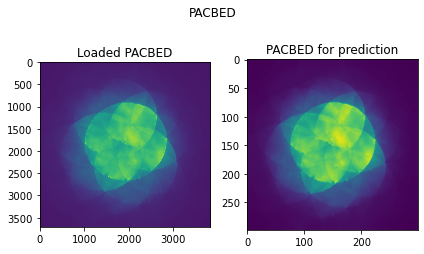

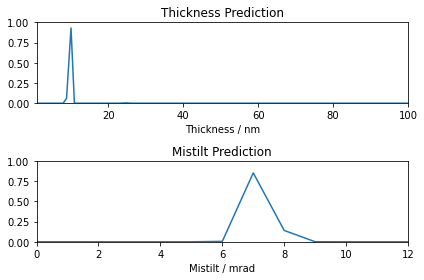

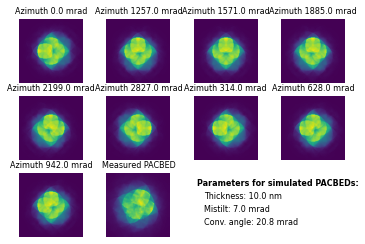

In [15]:
%lprun -f Predictor.validate predictor.validate(result)